In [ ]:
!pip install -q kaggle

In [ ]:
import os
import shutil

# Create the .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json into it
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

print("✅ Kaggle API key set up!")


✅ Kaggle API key set up!


In [ ]:
!kaggle datasets download -d dronio/SolarEnergy

Dataset URL: https://www.kaggle.com/datasets/dronio/SolarEnergy
License(s): DbCL-1.0


In [ ]:
import zipfile
import os

# Unzip the downloaded file
with zipfile.ZipFile("SolarEnergy.zip", "r") as zip_ref:
    zip_ref.extractall("solar_data")


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Data extraction
data = pd.read_csv('/content/SolarEnergy.zip')
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


<ipython-input-9-f8553d10e63e>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


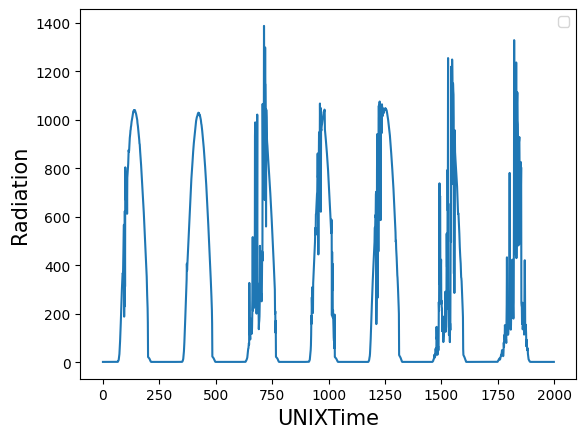

In [ ]:
#Radiation plot
ax=plt.gca()
ax.plot(data['Radiation'].iloc[:2000])
ax.set_xlabel('UNIXTime',size=15)
ax.set_ylabel('Radiation',size=15)
ax.legend()

In [ ]:
data_sun = data[['UNIXTime','Radiation']].iloc[:31000,:]
data_sun.set_index('UNIXTime',drop=True,inplace=True)
data_sun.tail()

,Radiation
UNIXTime,
1481318139,120.52
1481317850,107.32
1481317540,144.85
1481317251,179.73
1481316953,193.00


In [ ]:
#Applying a scaler for regression
MMS = MinMaxScaler()
data_sun[data_sun.columns] = MMS.fit_transform(data_sun)
data_sun.head()

,Radiation
UNIXTime,
1475229326,0.000062
1475229023,0.000062
1475228726,0.000075
1475228421,0.000062
1475228124,0.000037


In [ ]:
#Splitting in training and testing samples
training_size = round(len(data_sun) * 0.80)
train_data = data_sun[:training_size]
test_data  = data_sun[training_size:]

In [ ]:
def create_sequence(dataset,sequence_len):
  sequences = []
  labels = []
  start_idx = 0
  for stop_idx in range(sequence_len,len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [ ]:
X_train, y_train = create_sequence(train_data,100)
X_val, y_val = create_sequence(test_data,100)

print(X_train.shape, X_val.shape)

(24700, 100, 1) (6100, 100, 1)


In [ ]:
#Creating LSTM for regression

model = Sequential()
model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units = 32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0399 - val_loss: 0.0019 - val_mean_absolute_error: 0.0203
Epoch 2/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0032 - mean_absolute_error: 0.0276 - val_loss: 0.0019 - val_mean_absolute_error: 0.0216
Epoch 3/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0030 - mean_absolute_error: 0.0265 - val_loss: 0.0015 - val_mean_absolute_error: 0.0185
Epoch 4/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0031 - mean_absolute_error: 0.0254 - val_loss: 0.0015 - val_mean_absolute_error: 0.0155
Epoch 5/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0030 - mean_absolute_error: 0.0250 - val_loss: 0.0014 - val_mean_absolute_error: 0.0167
Epoch 6/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0028 - mean_absolute_error: 0.0243 - val_loss: 0.0016 - val_mean_absolute_error: 0.0192
Epoch 7/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0029 - mean_absolute_error:

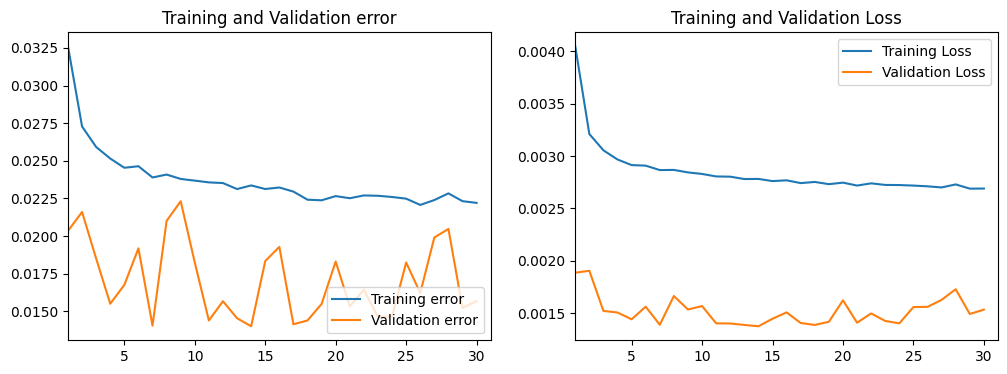

In [ ]:
#Plot of error and loss
error = history.history['mean_absolute_error']
val_error = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_error)+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, error, label='Training error')
plt.plot(epochs_range, val_error, label='Validation error')
plt.legend(loc='lower right')
plt.xlim(1, len(val_error)+1)
plt.title('Training and Validation error')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_error)+1)
plt.title('Training and Validation Loss')
plt.show()

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MSE: 0.0015, MAE: 0.0157


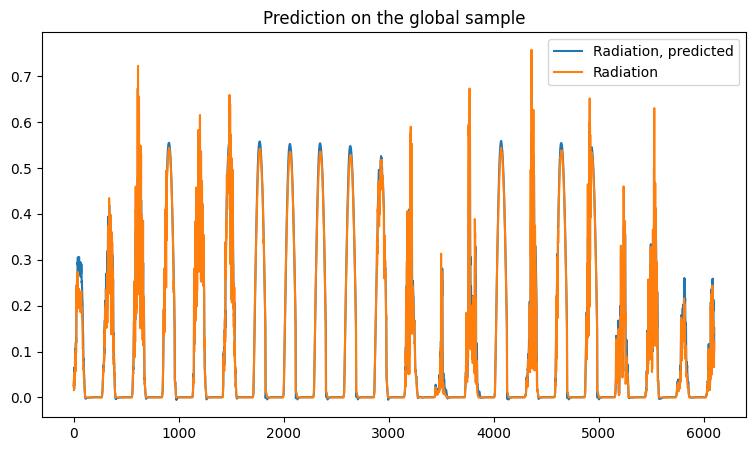

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_predicted = model.predict(X_val)

fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(test_predicted,label='Radiation, predicted')
plt.plot(y_val,label="Radiation")
plt.title('Prediction on the global sample')
plt.legend()
mse = mean_squared_error(y_val, test_predicted)
mae = mean_absolute_error(y_val, test_predicted)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

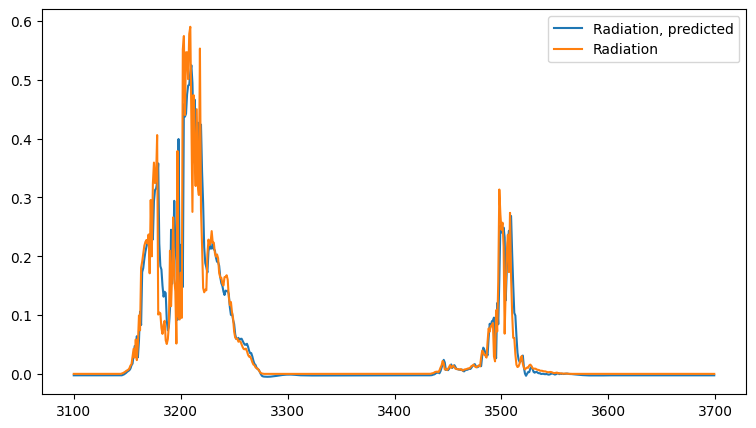

In [ ]:
fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(3100,3700),test_predicted[3100:3700],label='Radiation, predicted')
plt.plot(np.arange(3100,3700),y_val[3100:3700],label="Radiation")
plt.legend()